In [ ]:


! pip install pymongo==3.11.3

In [ ]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


 
MONGO_HOST= 'mongodb://localhost:27017/test'

client = MongoClient(MONGO_HOST)

# select database
db=client['plastic_waste']

#select the collection within the database
collection = db.plastic_waste

In [ ]:
# disply first document in the collection

result=collection.find()
result[1]['author']


{'created_at': '2016-01-25T10:20:43.000Z',
 'description': '',
 'id': '4845064486',
 'name': 'Sandra Forbes',
 'profile_image_url': 'https://pbs.twimg.com/profile_images/868495837021831169/ulMnYXwV_normal.jpg',
 'protected': False,
 'public_metrics': {'followers_count': 127,
  'following_count': 1111,
  'tweet_count': 13346,
  'listed_count': 0},
 'username': 's4bears',
 'verified': False}

## Top Users

In [ ]:
# find top 10 users based on number of tweets in this topic.
# find top 10 users based on number of tweets in this topic.

pipeline =[
  {"$group": {
    "_id": "$author.username",
    "numTweets": {"$sum":1}
  }
  },
  {"$sort": {"numTweets": -1}},
  {"$limit": 10}, 
  {"$project":{
        "userName": "$_id",
        "numTweets":1,
        "_id":0}
   }
]

result=collection.aggregate(pipeline)

result_list=[res for res in result]  # create an array to store the result

# convert result into pandas

result_pd = pd.DataFrame(result_list)

result_pd.head()



,numTweets,userName
0,32,OtisTheOracle
1,32,agoodthing_uk
2,25,PlasticWasteBot
3,19,Plasticsimpact
4,18,harishkumarsdmc


## [Choose a color palettes in seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html)

<AxesSubplot:xlabel='numTweets', ylabel='userName'>

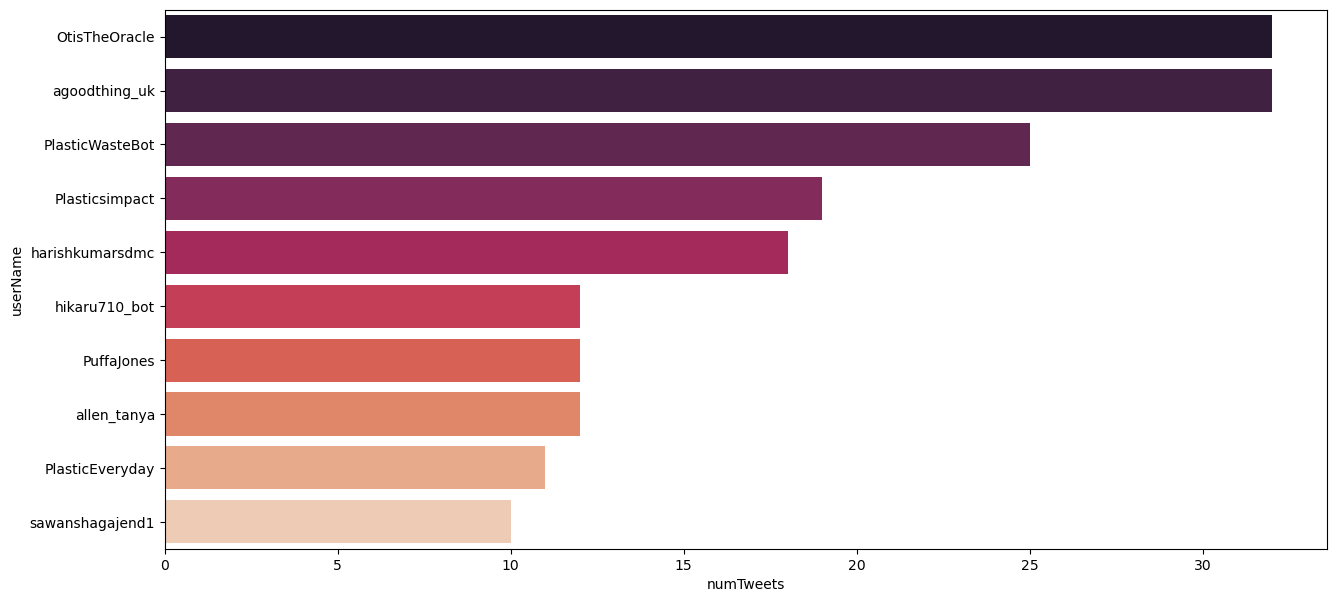

In [ ]:
# visualize the result

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("rocket", 10)

# plot a bar chart
sns.barplot(
    x="numTweets", 
    y="userName", 
    data=result_pd, 
    palette=palette)

In [ ]:
# define a function to return top N users based on number of tweets
def topNUsers(n):
    
    pipeline =[
      {"$group": {
    "_id": "$author.username",
    "numTweets": {"$sum":1}
      }
      },
      {"$sort": {"numTweets": -1}},
      {"$limit": n},
      {"$project":{
        "userName": "$_id",
        "numTweets":1,
        "_id":0    }
     }
    ]

    result=collection.aggregate(pipeline)
     
    result_pd = pd.DataFrame(res for res in result)
   
    return result_pd

<AxesSubplot:xlabel='numTweets', ylabel='userName'>

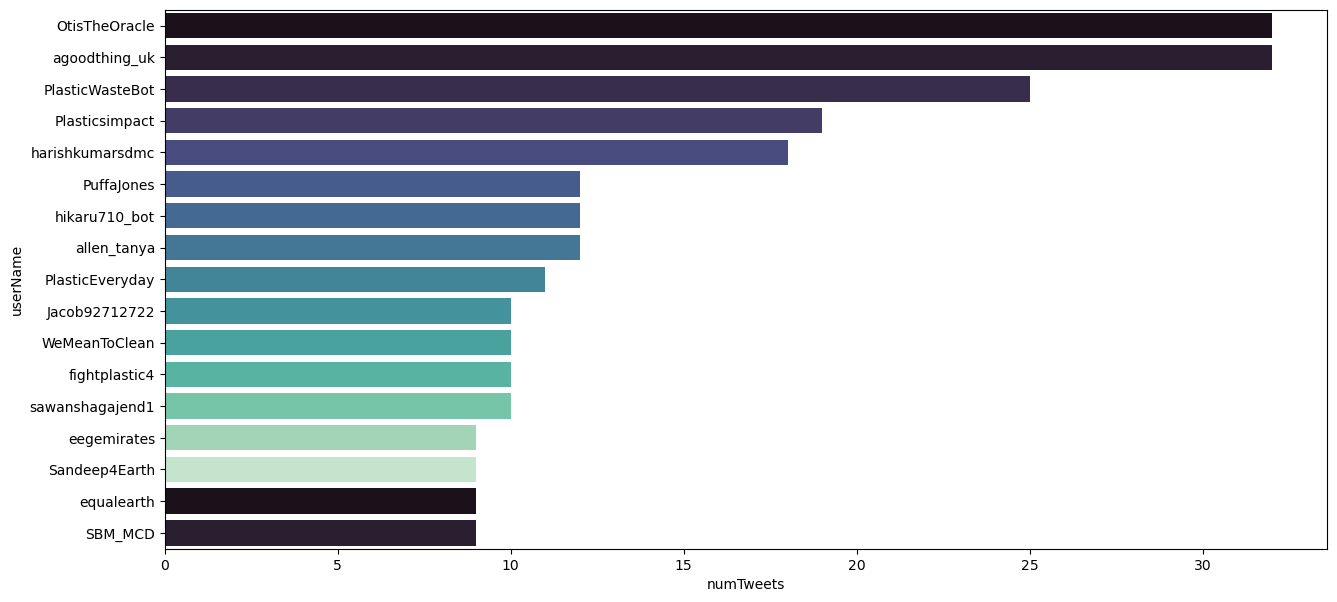

In [ ]:
result_pd=topNUsers(17)

# visualize the result

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 15 variations
palette=sns.color_palette("mako", 15)

# plot a bar chart
sns.barplot(
    x="numTweets", 
    y="userName", 
    data=result_pd, 
    palette=palette)

## Number of followers for top users

In [ ]:
pipeline =[
  {"$group": {
    "_id": "$author.username",
    "numTweets": {"$sum":1},
    "user_info":{"$push":{"followers_count":"$author.public_metrics.followers_count", 
                         "following_count": "$author.public_metrics.following_count"}}
  }
  },
  {"$sort": {"numTweets": -1}},
  {"$limit": 10},
  {"$project": {
    "user_name": "$_id",
    "numTweets":1,
    "followers_count": {"$max": "$user_info.followers_count"},
    "following_count": {"$max": "$user_info.following_count"},
    "_id":0
  }}
]

result=collection.aggregate(pipeline)

result_list=[res for res in result] 

result_pd = pd.DataFrame(result_list)

result_pd.head()

,numTweets,user_name,followers_count,following_count
0,32,OtisTheOracle,11,27
1,32,agoodthing_uk,1188,3348
2,25,PlasticWasteBot,10,0
3,19,Plasticsimpact,10679,9
4,18,harishkumarsdmc,5,9


## Create a combination chart

Text(0, 0.5, 'Followers Count')

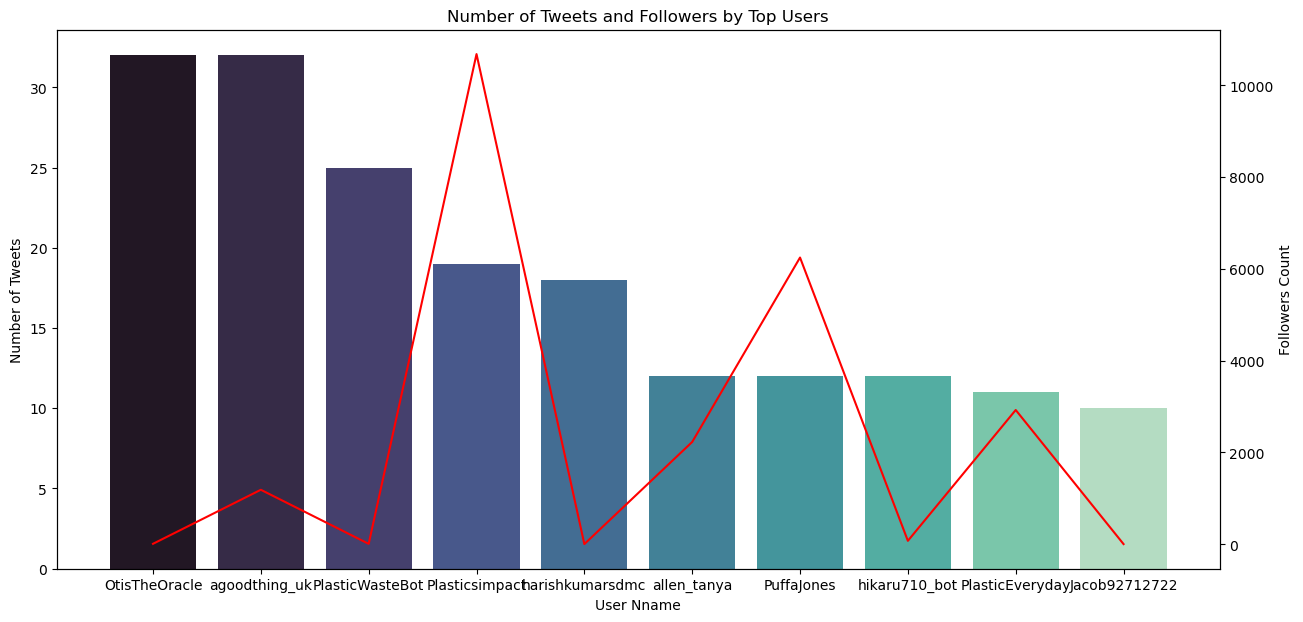

In [ ]:
# Set the figure size

plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("mako", 10)

# create a bar chart using seaborn

ax=sns.barplot(x="user_name", y="numTweets", data=result_pd, palette=palette)

# create a line chart using seaborn and Matplotlib

ax2=ax.twinx()

ax2.plot(result_pd["user_name"], result_pd["followers_count"], color="red")

# set the chart title and labels
ax.set_title("Number of Tweets and Followers by Top Users")
ax.set_xlabel("User Name")
ax.set_ylabel("Number of Tweets")
ax2.set_ylabel("Followers Count")

# Top annotation in the text

In [ ]:
# display top annotation mentioned in the text

# type can be place, organization, person, product and other

def topNAnnotation(topN=10, type='place'):
    pipeline =[
    {"$unwind": "$entities.annotations"},
    {"$addFields": {"type": {"$toLower": "$entities.annotations.type"}}},
    {"$addFields": {"normalized_text": {"$toLower": "$entities.annotations.normalized_text"}}},
    {"$group": {
        "_id": {"type": "$type"},
        "entity_list": {"$push":"$normalized_text"}
    }},
    {"$match": {"_id.type": type}},
    {"$unwind": "$entity_list"},
    {"$group":{
        "_id":"$entity_list",
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":topN}]
    
    result=collection.aggregate(pipeline)

    result_list=[]  # create am array to store the result

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [ ]:
types=['place', 'organization', 'person', 'product', 'other']

# create an empty pandas
total_df = pd.DataFrame()

for type in types:
    topN=topNAnnotation(10, type)
    topN['type']=type
    total_df=pd.concat([total_df, topN], axis=0) 

[Text(0.5, 0, 'Number of Tweets'),
 Text(0, 0.5, 'Place'),
 Text(0.5, 1.0, 'Top Places Mentioned in Tweets')]

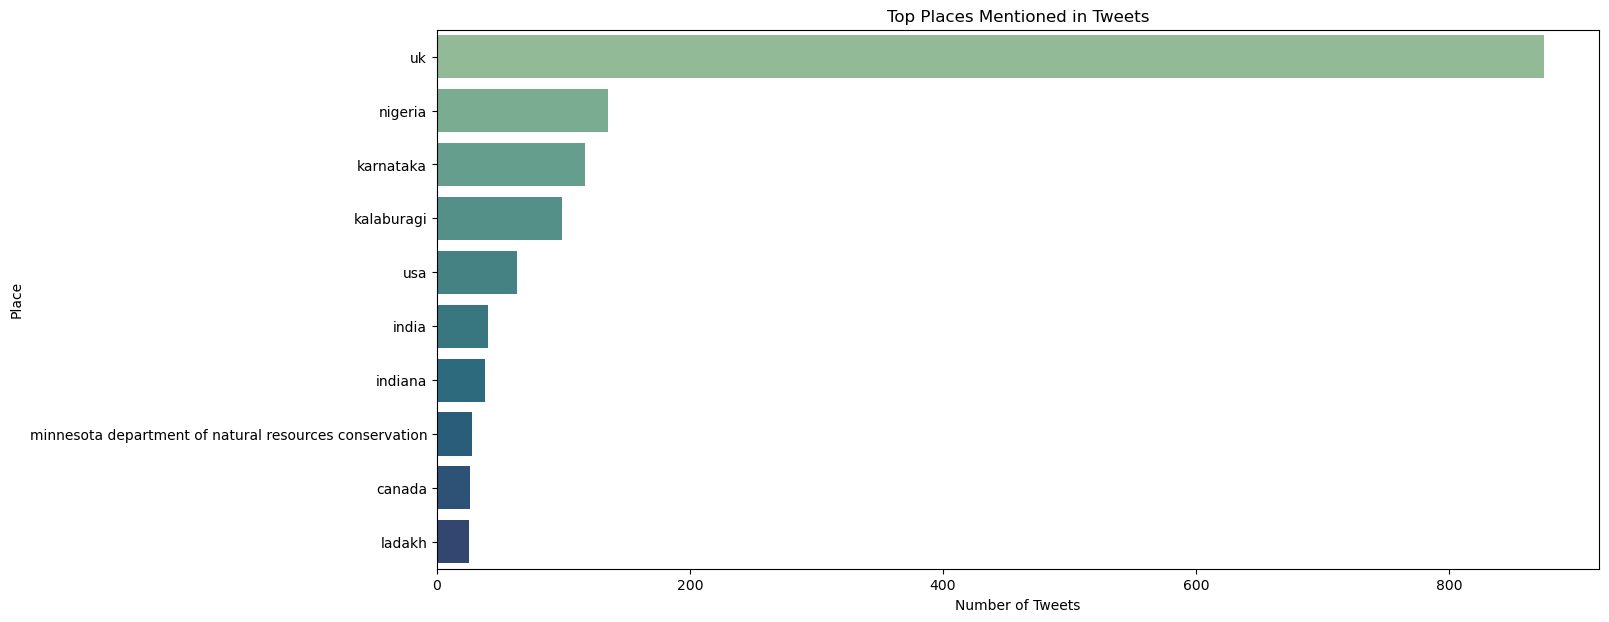

In [ ]:
# visualize the result

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("crest", 10)

# plot a bar chart
ax=sns.barplot(
    x="frequency", 
    y="_id", 
    data=total_df[total_df.type=='place'], 
    palette=palette)

ax.set(xlabel="Number of Tweets", ylabel="Place", title="Top Places Mentioned in Tweets")

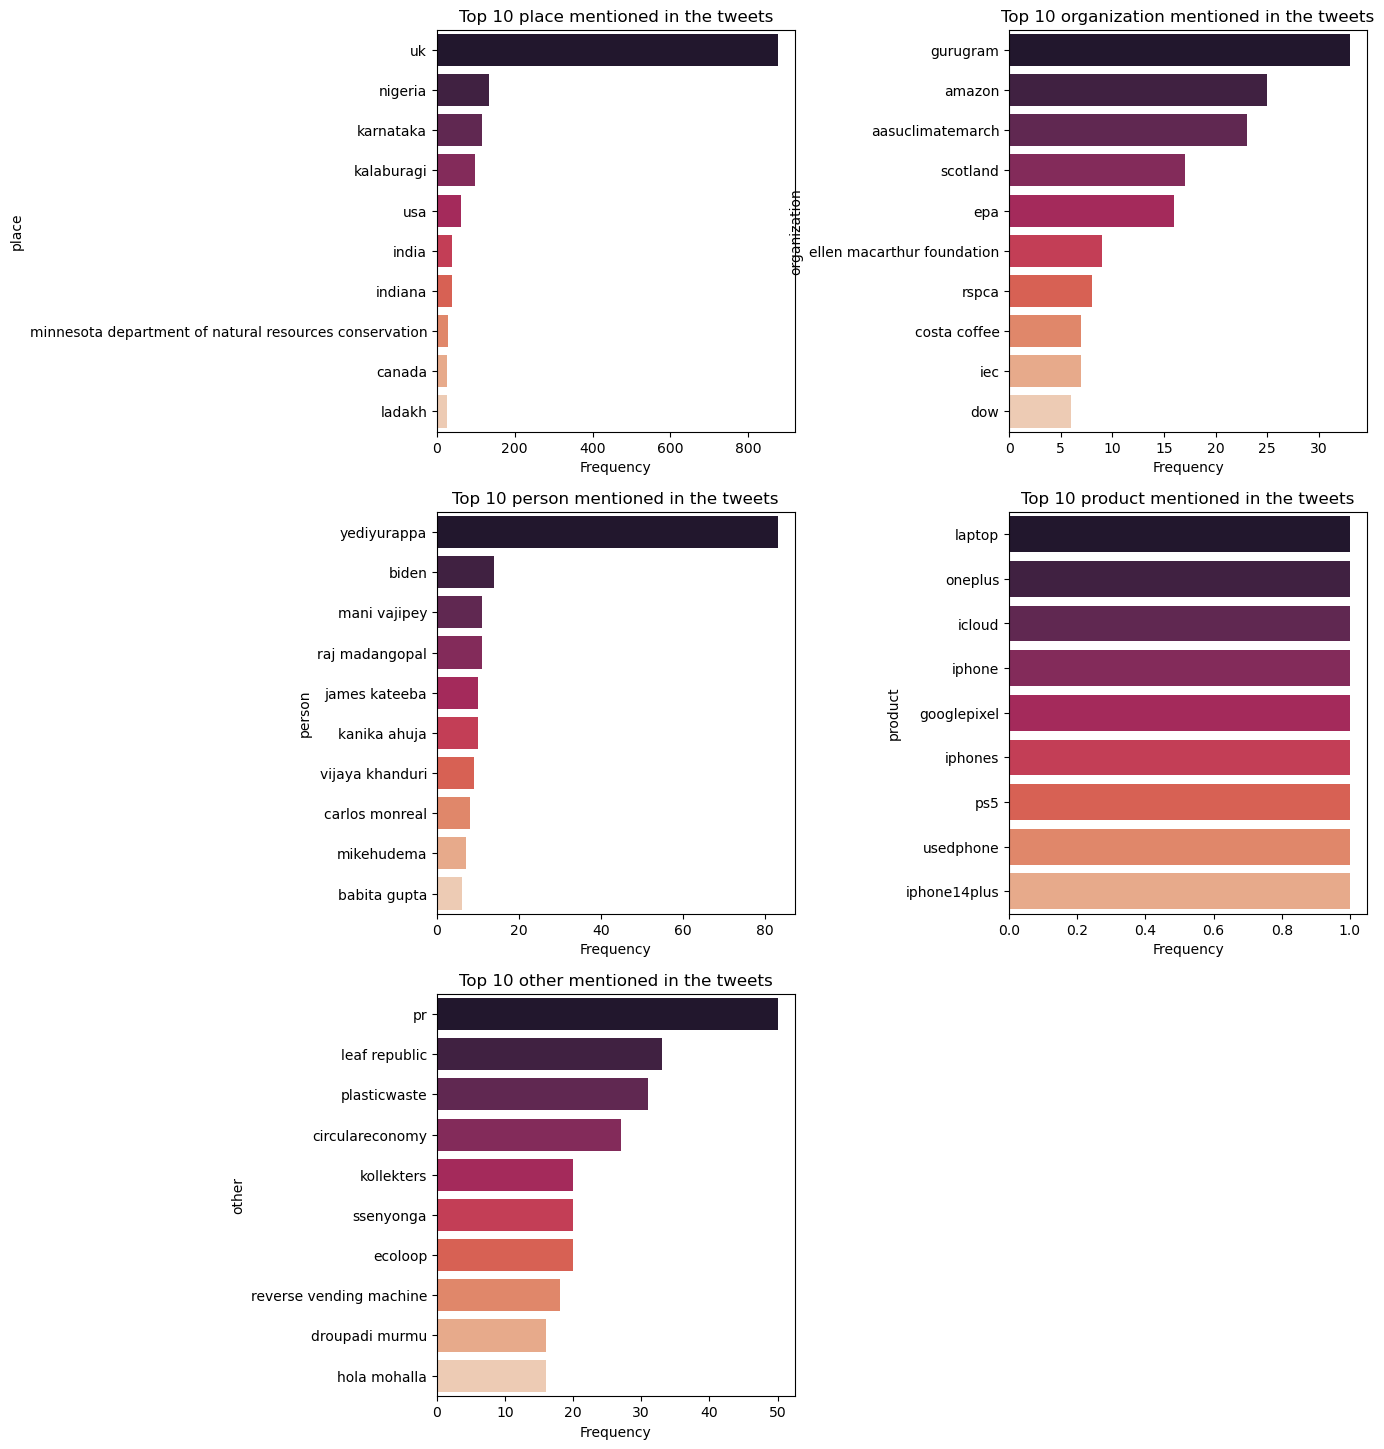

In [ ]:
import matplotlib.pyplot as plt
i=1


fig = plt.figure(figsize=(12,24)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

types=['place', 'organization', 'person', 'product', 'other']

for type in types:
    
    plt.subplot(4,2,i)   #create a 4 by 2 subplot 
   
    data=total_df[total_df.type==type]
    
    # use a sequential color with 10 variations
    palette=sns.color_palette("rocket", 10)

    # plot a bar chart
    sns.barplot( x="frequency", 
    y="_id", 
    data=data, 
    palette=palette)
    
    # add label
    plt.xlabel('Frequency')
    plt.ylabel(type)
    plt.title("Top 10 "+type+ " mentioned in the tweets")
    i=i+1

## Top Hashtags

In [ ]:
# display top N hashtags

def topNHashtags(n):
    
    pipeline =[
    {"$unwind": "$entities.hashtags"},
    {"$addFields": {"hashtags": {"$toLower": "$entities.hashtags.tag"}}},
    {"$match": {"hashtags": {"$nin": ["plasticwaste", "zerowaste", "recycle"]}}},
    {"$group": {
        "_id": {"hashtag": "$hashtags"},
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":n},
    {"$project":{
        "hashtag": "$_id.hashtag",
        "frequency":1,
        "_id":0    }
    }
    ]
    
    result=collection.aggregate(pipeline)

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [ ]:
top10hashtags=topNHashtags(10)

top10hashtags

,frequency,hashtag
0,800,chooseloose
1,222,recycling
2,196,environment
3,183,watch
4,162,plastic
5,141,sustainability
6,137,reuse
7,120,climatechange
8,110,plasticfree
9,108,savetheplanet


<AxesSubplot:xlabel='frequency', ylabel='hashtag'>

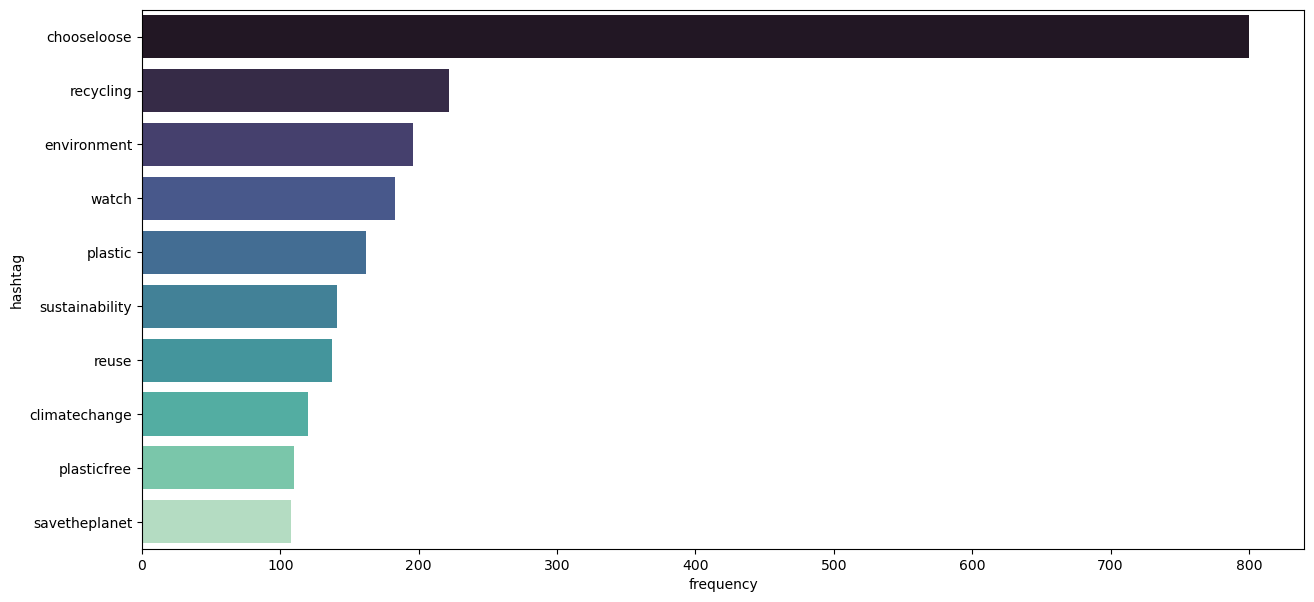

In [ ]:
# visualize the result

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("mako", 10)

# plot a bar chart
sns.barplot(
    x="frequency", 
    y="hashtag", 
    data=top10hashtags, 
    palette=palette)

In [ ]:
# top N hashtags by weekday

def topNHashtagsByWeekday(n):
    pipeline=[
    {"$addFields": {"weekday": {"$dayOfWeek": {"$toDate": "$created_at"}}}},
    {"$unwind": "$entities.hashtags"},
    {"$addFields": {"hashtags": {"$toLower": "$entities.hashtags.tag"}}},
    {"$match": {"hashtags": {"$nin": ["plasticwaste", "zerowaste", "recycle"]}}},
    {"$group": {
        "_id": {"weekday": "$weekday", "hashtag":"$hashtags"},
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$group":{
        "_id": "$_id.weekday",
        "hashtags": {"$push": {"hashtag": "$_id.hashtag", "frequency": "$frequency"}}
    }},
    {"$sort": {"_id.weekday":1}},
    {"$project":{
        "top10Hashtags": {"$slice":["$hashtags", 0, n]}
    }},
    {"$unwind": "$top10Hashtags"},
    {"$project":{
        "weekday": "$_id",
        "hashtag": "$top10Hashtags.hashtag",
       "frequency": "$top10Hashtags.frequency",
        "_id":0
    }}    
   ]

    result=collection.aggregate(pipeline)

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [ ]:
result_pd=topNHashtagsByWeekday(10)
result_pd

,weekday,hashtag,frequency
0,5,chooseloose,178
1,5,sustainability,36
2,5,environment,33
3,5,circulareconomy,32
4,5,plastic,31
5,5,waste,29
6,5,recycling,29
7,5,plasticpollution,25
8,5,reuse,19
9,5,climatechange,16


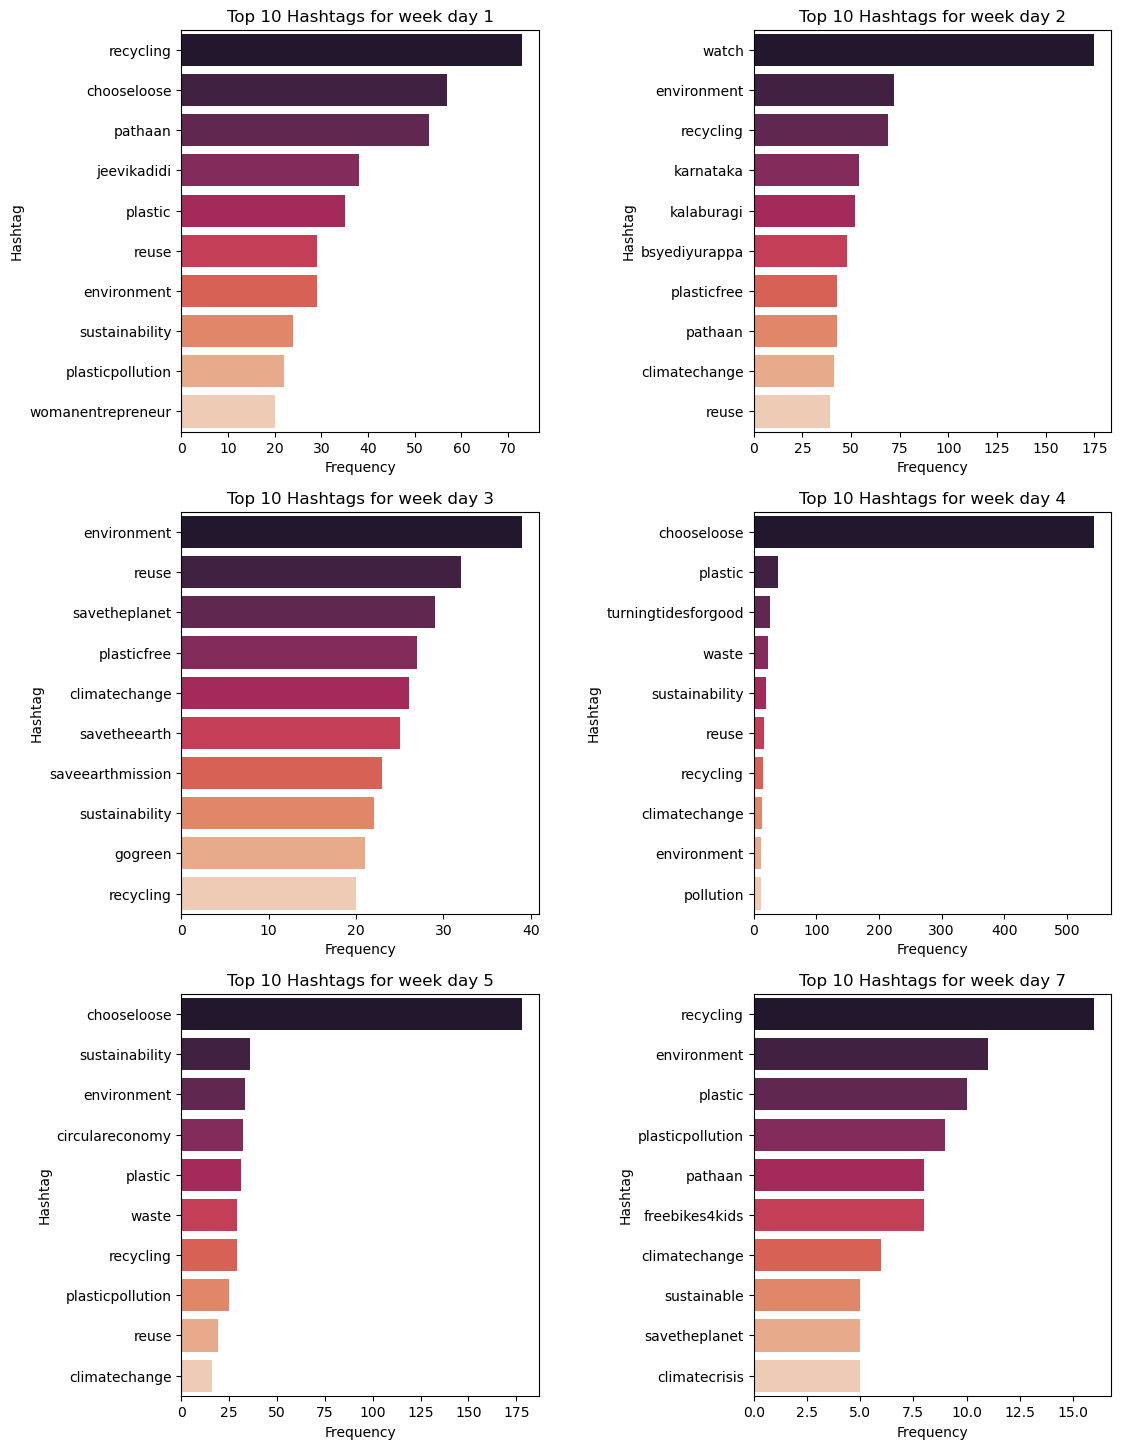

In [ ]:
import matplotlib.pyplot as plt
i=1
numWeekdays=result_pd.weekday.unique() #find the unique week days in the result
numWeekdays.sort() #sort the week day by ascending order

fig = plt.figure(figsize=(12,24)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

for weekday in numWeekdays:
    plt.subplot(4,2,i)   #create a 4 by 2 subplot 
    weekdayResult_pd=result_pd[result_pd["weekday"]==weekday]
    
    # use a sequential color with 10 variations
    palette=sns.color_palette("rocket", 10)

    # plot a bar chart
    sns.barplot( x="frequency", 
    y="hashtag", 
    data=weekdayResult_pd, 
    palette=palette)
    
    # add label
    plt.xlabel('Frequency')
    plt.ylabel("Hashtag")
    plt.title("Top 10 Hashtags for week day "+str(weekday))
    i=i+1

In [ ]:
top100hashtags=topNHashtags(100)

top100hashtags

,frequency,hashtag
0,800,chooseloose
1,222,recycling
2,196,environment
3,183,watch
4,162,plastic
...,...,...
95,10,wmtcblog
96,10,lighting
97,10,diy
98,10,bsyeddyurappa


## Visualize top hashtags

In [ ]:
# install wordcloud

!pip install wordcloud

In [ ]:
# pick top 100 words and convert the result into a dictionary

tophashtags=topNHashtags(100)

result_dict=dict(zip(tophashtags["hashtag"], tophashtags['frequency']))

#result_dict

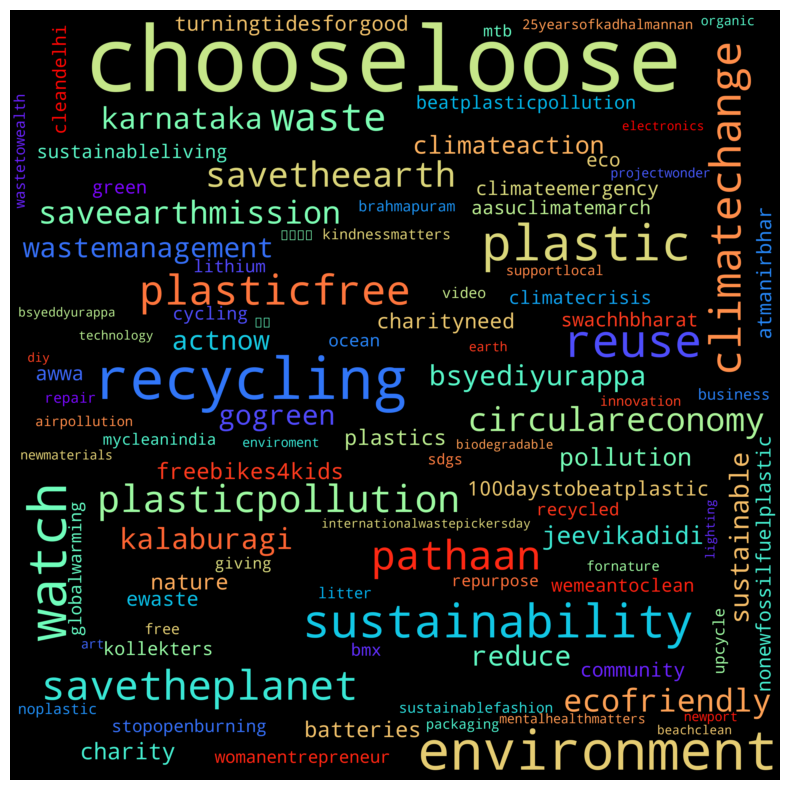

In [ ]:
from wordcloud import WordCloud
from PIL import Image

# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=True, background_color='black',colormap='rainbow')

# generate the word cloud
wordcloud.generate_from_frequencies(result_dict)

#plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
pipeline =[
   {"$project": {
   "tweet_id": "$id_str",
    "created_at":1,
    "user_name":"$author.name",
    "user_screenName": "$author.username",
    "user_place": "$author.location",
    "text":1,
    "lang":1,
     "_id":0
  }
  }
]

result=collection.aggregate(pipeline)

result_list=[res for res in result]  # create an array to store the result

# convert result list into pandas data frame

result_pd = pd.DataFrame(result_list)

result_pd.head()

,created_at,lang,text,user_name,user_screenName,user_place
0,2023-03-01T07:49:25.000Z,en,@vpostrel @bswud I remember waste tires being ...,etbadaboum,etbadabim,France
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes...,Sandra Forbes,s4bears,NaN
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔...,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom"
3,2023-03-01T07:51:25.000Z,en,RT @Green_Earth2022: More than 8 million tons ...,Annelie Moser,AnnelieMoser,Idar-oberstein
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes...,Kimberley Tighe💙,KimberleyTighe,NaN


In [ ]:
result=collection.find()
result[0]['text']

'@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?'

## Sentiment Analysis

In [ ]:
 ! pip install vaderSentiment==3.3.2
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_sent(text):
    vader_sent=analyzer.polarity_scores(text)
    return vader_sent
    
result_pd['vader_sent']=result_pd['text'].apply(vader_sent)

In [ ]:

pd.set_option('display.max_columns', None) 
pd.options.display.max_colwidth = 300  
pd.set_option('display.max_rows', 10)
result_pd.head()

,created_at,lang,text,user_name,user_screenName,user_place,vader_sent
0,2023-03-01T07:49:25.000Z,en,"@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?",etbadaboum,etbadabim,France,"{'neg': 0.114, 'neu': 0.813, 'pos': 0.074, 'compound': -0.2467}"
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Sandra Forbes,s4bears,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔🙄\nNot like we knew that 3 years ago whilst the plastic #tories and #LabourParty made political out of it.\n\nTories played with stats\n\nLabour egged them on to worsen the socioeconomic outcome,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom","{'neg': 0.156, 'neu': 0.798, 'pos': 0.046, 'compound': -0.7013}"
3,2023-03-01T07:51:25.000Z,en,"RT @Green_Earth2022: More than 8 million tons of plastic waste enters our oceans every year. Not only does it harm marine life, it also con…",Annelie Moser,AnnelieMoser,Idar-oberstein,"{'neg': 0.215, 'neu': 0.785, 'pos': 0.0, 'compound': -0.743}"
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Kimberley Tighe💙,KimberleyTighe,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [ ]:
result_pd['sentiment']=result_pd['vader_sent'].apply(pd.Series)['compound']

result_pd.head()

,created_at,lang,text,user_name,user_screenName,user_place,vader_sent,sentiment
0,2023-03-01T07:49:25.000Z,en,"@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?",etbadaboum,etbadabim,France,"{'neg': 0.114, 'neu': 0.813, 'pos': 0.074, 'compound': -0.2467}",-0.2467
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Sandra Forbes,s4bears,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔🙄\nNot like we knew that 3 years ago whilst the plastic #tories and #LabourParty made political out of it.\n\nTories played with stats\n\nLabour egged them on to worsen the socioeconomic outcome,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom","{'neg': 0.156, 'neu': 0.798, 'pos': 0.046, 'compound': -0.7013}",-0.7013
3,2023-03-01T07:51:25.000Z,en,"RT @Green_Earth2022: More than 8 million tons of plastic waste enters our oceans every year. Not only does it harm marine life, it also con…",Annelie Moser,AnnelieMoser,Idar-oberstein,"{'neg': 0.215, 'neu': 0.785, 'pos': 0.0, 'compound': -0.743}",-0.7430
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Kimberley Tighe💙,KimberleyTighe,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000


In [ ]:
result_pd['sentiment'].mean()

-0.013918854473942727

In [ ]:
result_pd['sentiment'].describe()

count    8136.000000
mean       -0.013919
std         0.480150
min        -0.968200
25%        -0.421500
50%         0.000000
75%         0.296000
max         0.988700
Name: sentiment, dtype: float64

In [ ]:
def sent_classify(score):
    if score>0.05:
        return "Positive"
    elif score<-0.05:
        return "Negative"
    else:
        return "Neutral"

result_pd['sentiment_label']=result_pd['sentiment'].apply(sent_classify)
result_sent=result_pd.groupby('sentiment_label')['sentiment_label'].count()
result_sent

sentiment_label
Negative    3260
Neutral     1588
Positive    3288
Name: sentiment_label, dtype: int64

In [ ]:
result_sent2=result_sent.rename("totalTweets").reset_index()

result_sent2.head()

,sentiment_label,totalTweets
0,Negative,3260
1,Neutral,1588
2,Positive,3288


Text(0, 0.5, 'Number of Tweets')

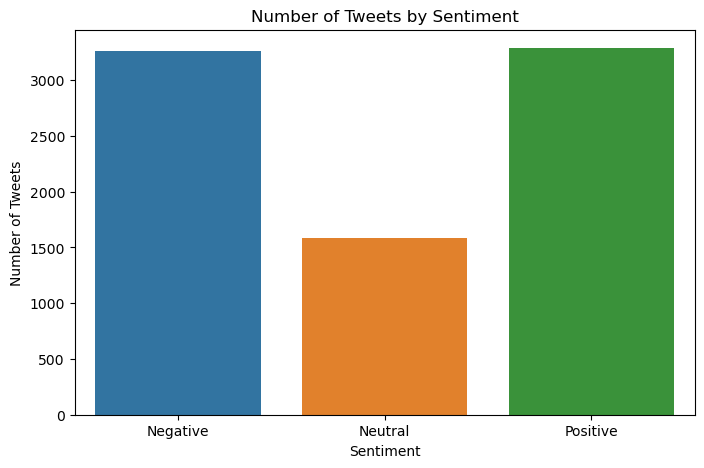

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size
plt.figure(figsize=(8,5))

# use a color palette
palette=sns.color_palette("tab10")

# plot a bar chart
ax=sns.barplot(
    x="sentiment_label", 
    y="totalTweets", 
    data=result_sent2,
    palette=palette)

ax.set_title("Number of Tweets by Sentiment")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Number of Tweets")

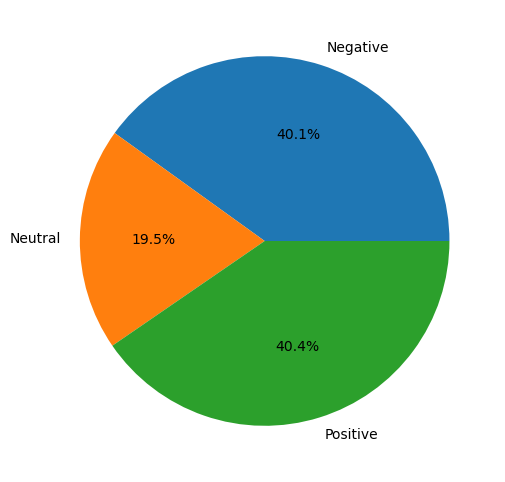

In [ ]:
ax=result_sent2.set_index('sentiment_label').plot.pie(y='totalTweets', autopct="%1.1f%%", figsize=(6,6))

ax.set_ylabel("")

plt.legend().remove()

In [ ]:
def identify_keywords(text, keywords):
    result={}
    for keyword in keywords:
        if keyword in text:
            result[keyword]='Yes'
        else:
            result[keyword]="No"
        
    return result

In [ ]:
keywords=["plasticwaste", "zerowaste", "recycle"]

result_pd['text_lower']=result_pd.text.str.lower()

result_pd['keywords']=result_pd.text_lower.apply(lambda x: identify_keywords(x, keywords))

In [ ]:
keywords_list=result_pd['keywords'].apply(pd.Series)
result_pd2=pd.concat([result_pd, keywords_list], axis=1)

result_pd2.head(5)

,created_at,lang,text,user_name,user_screenName,user_place,vader_sent,sentiment,sentiment_label,text_lower,keywords,plasticwaste,zerowaste,recycle
0,2023-03-01T07:49:25.000Z,en,"@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?",etbadaboum,etbadabim,France,"{'neg': 0.114, 'neu': 0.813, 'pos': 0.074, 'compound': -0.2467}",-0.2467,Negative,"@vpostrel @bswud i remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",No,No,No
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Sandra Forbes,s4bears,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",No,No,No
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔🙄\nNot like we knew that 3 years ago whilst the plastic #tories and #LabourParty made political out of it.\n\nTories played with stats\n\nLabour egged them on to worsen the socioeconomic outcome,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom","{'neg': 0.156, 'neu': 0.798, 'pos': 0.046, 'compound': -0.7013}",-0.7013,Negative,#lockdowns were a waste of time.\nfancy that 🤔🙄\nnot like we knew that 3 years ago whilst the plastic #tories and #labourparty made political out of it.\n\ntories played with stats\n\nlabour egged them on to worsen the socioeconomic outcome,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",No,No,No
3,2023-03-01T07:51:25.000Z,en,"RT @Green_Earth2022: More than 8 million tons of plastic waste enters our oceans every year. Not only does it harm marine life, it also con…",Annelie Moser,AnnelieMoser,Idar-oberstein,"{'neg': 0.215, 'neu': 0.785, 'pos': 0.0, 'compound': -0.743}",-0.7430,Negative,"rt @green_earth2022: more than 8 million tons of plastic waste enters our oceans every year. not only does it harm marine life, it also con…","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",No,No,No
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Kimberley Tighe💙,KimberleyTighe,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",No,No,No


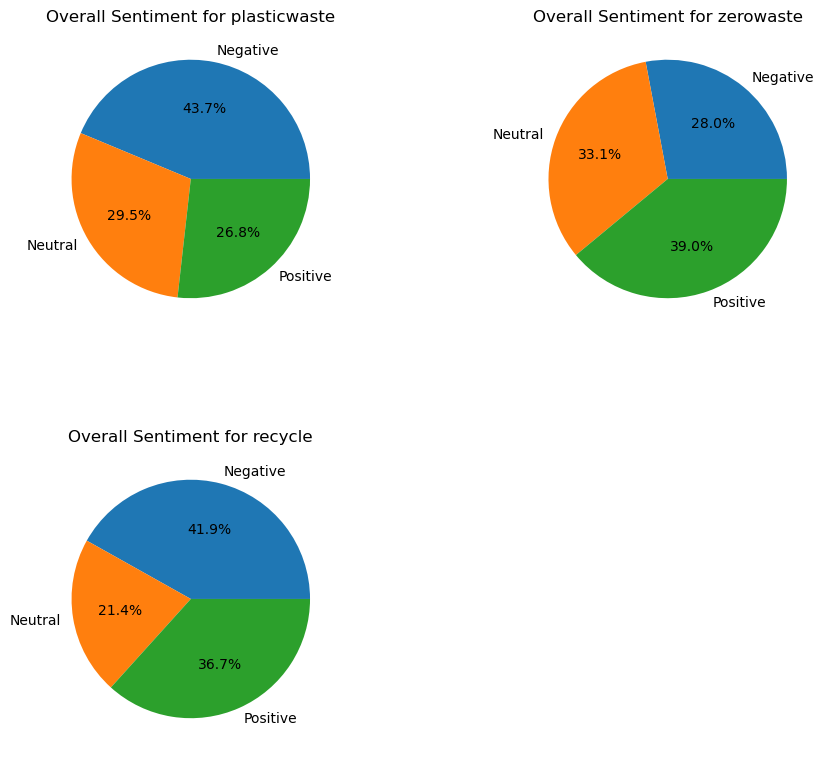

In [ ]:

keywords=["plasticwaste", "zerowaste", "recycle"]

i=1

fig = plt.figure(figsize=(20,20)) # define the size of the figure

fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

for keyword in keywords:
    plt.subplot(2,2,i)   # create a 2 by 2 subplot
    
    result=result_pd2[result_pd2[keyword]=='Yes'].groupby('sentiment_label')['sentiment_label'].count()
    df=pd.DataFrame(result)
    df.columns=['numTweets']
    ax=result.plot.pie(y='numTweets', autopct="%1.1f%%", figsize=(10,10))
    ax.set_ylabel("")
    plt.title("Overall Sentiment for " + keyword)
    plt.legend().remove()
    i=i+1

## GENDER GUESSER

In [ ]:
!pip install gender_guesser

     ------------------------------------- 379.3/379.3 kB 11.9 MB/s eta 0:00:00


In [ ]:
names = result_pd["user_name"].str.split(" ", n = 1, expand = True)
names.head(10)

,0,1
0,etbadaboum,None
1,Sandra,Forbes
2,©️h®️!$,'71 🦏
3,Annelie,Moser
4,Kimberley,Tighe💙
5,©️h®️!$,'71 🦏
6,GARIMA,None
7,Lila,None
8,Bethanie,Carney Almroth #PlasticsTreaty
9,Vince,None


In [ ]:
result_pd['First'] = names[0]

result_pd.head()

,created_at,lang,text,user_name,user_screenName,user_place,vader_sent,sentiment,sentiment_label,text_lower,keywords,First
0,2023-03-01T07:49:25.000Z,en,"@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?",etbadaboum,etbadabim,France,"{'neg': 0.114, 'neu': 0.813, 'pos': 0.074, 'compound': -0.2467}",-0.2467,Negative,"@vpostrel @bswud i remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",etbadaboum
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Sandra Forbes,s4bears,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Sandra
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔🙄\nNot like we knew that 3 years ago whilst the plastic #tories and #LabourParty made political out of it.\n\nTories played with stats\n\nLabour egged them on to worsen the socioeconomic outcome,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom","{'neg': 0.156, 'neu': 0.798, 'pos': 0.046, 'compound': -0.7013}",-0.7013,Negative,#lockdowns were a waste of time.\nfancy that 🤔🙄\nnot like we knew that 3 years ago whilst the plastic #tories and #labourparty made political out of it.\n\ntories played with stats\n\nlabour egged them on to worsen the socioeconomic outcome,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",©️h®️!$
3,2023-03-01T07:51:25.000Z,en,"RT @Green_Earth2022: More than 8 million tons of plastic waste enters our oceans every year. Not only does it harm marine life, it also con…",Annelie Moser,AnnelieMoser,Idar-oberstein,"{'neg': 0.215, 'neu': 0.785, 'pos': 0.0, 'compound': -0.743}",-0.7430,Negative,"rt @green_earth2022: more than 8 million tons of plastic waste enters our oceans every year. not only does it harm marine life, it also con…","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Annelie
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Kimberley Tighe💙,KimberleyTighe,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Kimberley


In [ ]:
import gender_guesser.detector as gender

g = gender.Detector()

In [ ]:
for index, row in result_pd[0:10].iterrows():
    print(row['First'], g.get_gender(row['First']))

etbadaboum unknown
Sandra female
©️h®️!$ unknown
Annelie female
Kimberley female
©️h®️!$ unknown
GARIMA unknown
Lila female
Bethanie female
Vince male


In [ ]:

result_pd['First'] = names[0].str.lower().str.capitalize()

result_pd

,created_at,lang,text,user_name,user_screenName,user_place,vader_sent,sentiment,sentiment_label,text_lower,keywords,First,gender
0,2023-03-01T07:49:25.000Z,en,"@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?",etbadaboum,etbadabim,France,"{'neg': 0.114, 'neu': 0.813, 'pos': 0.074, 'compound': -0.2467}",-0.2467,Negative,"@vpostrel @bswud i remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Etbadaboum,unknown
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Sandra Forbes,s4bears,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Sandra,female
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔🙄\nNot like we knew that 3 years ago whilst the plastic #tories and #LabourParty made political out of it.\n\nTories played with stats\n\nLabour egged them on to worsen the socioeconomic outcome,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom","{'neg': 0.156, 'neu': 0.798, 'pos': 0.046, 'compound': -0.7013}",-0.7013,Negative,#lockdowns were a waste of time.\nfancy that 🤔🙄\nnot like we knew that 3 years ago whilst the plastic #tories and #labourparty made political out of it.\n\ntories played with stats\n\nlabour egged them on to worsen the socioeconomic outcome,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",©️h®️!$,unknown
3,2023-03-01T07:51:25.000Z,en,"RT @Green_Earth2022: More than 8 million tons of plastic waste enters our oceans every year. Not only does it harm marine life, it also con…",Annelie Moser,AnnelieMoser,Idar-oberstein,"{'neg': 0.215, 'neu': 0.785, 'pos': 0.0, 'compound': -0.743}",-0.7430,Negative,"rt @green_earth2022: more than 8 million tons of plastic waste enters our oceans every year. not only does it harm marine life, it also con…","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Annelie,female
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Kimberley Tighe💙,KimberleyTighe,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Kimberley,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8131,2023-03-07T15:11:09.000Z,en,"Offset your carbon footprint with Zero Waste Box! On average, the Plastic Packaging Box recycles 14 lbs of trash! Offset your carbon footprint by recycling with Zero Waste Box! 🤩\n\nShop Now! https://t.co/CmG72QlBQg https://t.co/jayMj8WHUz",TerraCycle Canada,TerraCycleCA,Toronto,"{'neg': 0.175, 'neu': 0.825, 'pos': 0.0, 'compound': -0.7762}",-0.7762,Negative,"offset your carbon footprint with zero waste box! on average, the plastic packaging box recycles 14 lbs of trash! offset your carbon footprint by recycling with zero waste box! 🤩\n\nshop now! https://t.co/cmg72qlbqg https://t.co/jaymj8whuz","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'Yes'}",Terracycle,unknown
8132,2023-03-07T15:11:55.000Z,en,@A_S_Nassir The county government of Mombasa can come up with something big since we already have those trucks that collect garbage on streets.Teaching every household to separate the waste that can be recycled eg plastic .,Vector45,Vector458,NaN,"{'neg': 0.074, 'neu': 0.926, 'pos': 0.0, 'compound': -0.4215}",-0.4215,Neg

In [ ]:
genderguess = []

for index, row in result_pd.iterrows():
    genderguess.append(g.get_gender(row['First']))
    
result_pd['gender'] = genderguess

result_pd.head()


,created_at,lang,text,user_name,user_screenName,user_place,vader_sent,sentiment,sentiment_label,text_lower,keywords,First,gender
0,2023-03-01T07:49:25.000Z,en,"@vpostrel @bswud I remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?",etbadaboum,etbadabim,France,"{'neg': 0.114, 'neu': 0.813, 'pos': 0.074, 'compound': -0.2467}",-0.2467,Negative,"@vpostrel @bswud i remember waste tires being repurposed into children playground soft surface being pointed at for health reasons, no risk here?","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Etbadaboum,unknown
1,2023-03-01T07:49:47.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Sandra Forbes,s4bears,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Sandra,female
2,2023-03-01T07:50:08.000Z,en,#Lockdowns were a waste of time.\nFancy that 🤔🙄\nNot like we knew that 3 years ago whilst the plastic #tories and #LabourParty made political out of it.\n\nTories played with stats\n\nLabour egged them on to worsen the socioeconomic outcome,©️h®️!$ '71 🦏,C16447628,"England, United Kingdom","{'neg': 0.156, 'neu': 0.798, 'pos': 0.046, 'compound': -0.7013}",-0.7013,Negative,#lockdowns were a waste of time.\nfancy that 🤔🙄\nnot like we knew that 3 years ago whilst the plastic #tories and #labourparty made political out of it.\n\ntories played with stats\n\nlabour egged them on to worsen the socioeconomic outcome,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",©️h®️!$,unknown
3,2023-03-01T07:51:25.000Z,en,"RT @Green_Earth2022: More than 8 million tons of plastic waste enters our oceans every year. Not only does it harm marine life, it also con…",Annelie Moser,AnnelieMoser,Idar-oberstein,"{'neg': 0.215, 'neu': 0.785, 'pos': 0.0, 'compound': -0.743}",-0.7430,Negative,"rt @green_earth2022: more than 8 million tons of plastic waste enters our oceans every year. not only does it harm marine life, it also con…","{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Annelie,female
4,2023-03-01T07:51:34.000Z,en,RT @vanessa_vash: Have you ever bought clothes? Then you need to watch this. \n\nA new investigation and documentary by ⁦@ChangingMarkets⁩ an…,Kimberley Tighe💙,KimberleyTighe,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral,rt @vanessa_vash: have you ever bought clothes? then you need to watch this. \n\na new investigation and documentary by ⁦@changingmarkets⁩ an…,"{'plasticwaste': 'No', 'zerowaste': 'No', 'recycle': 'No'}",Kimberley,female


<AxesSubplot:xlabel='gender', ylabel='sentiment'>

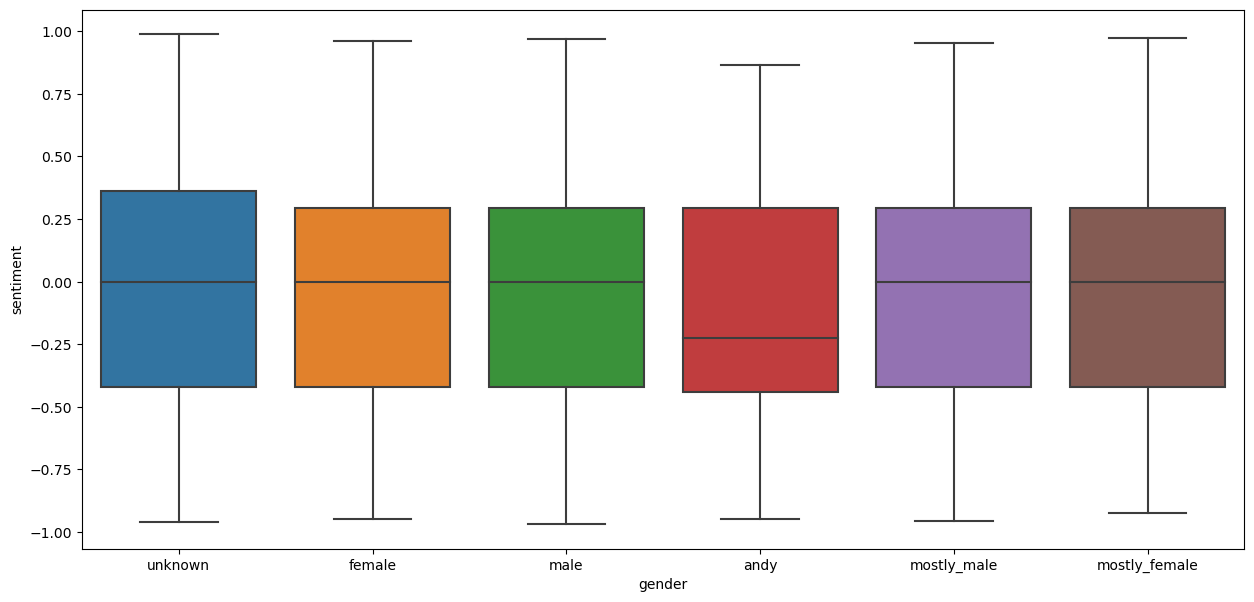

In [ ]:
plt.figure(figsize=(15, 7))


sns.boxplot(x='gender', y='sentiment', data=result_pd)

In [ ]:
result_pd.to_csv("plasticwaste.csv", sep="|", index=False)

In [ ]:
df=pd.read_csv("plasticwaste.csv", sep="|")